In [4]:
!python -V

Python 3.12.1


In [5]:
import pandas as pd
import numpy as np

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import pickle

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    df[numerical] = df[numerical].astype(float)
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [11]:
# categorical = ['PULocationID', 'DOLocationID']
# numerical = ['trip_distance']
# categorical + numerical
# output: ['PULocationID', 'DOLocationID', 'trip_distance']

In [12]:
df_train['PU_DO'] = df_train['PULocationID']+ '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID']+ '_' + df_val['DOLocationID']

categorical = ['PU_DO']
numerical = ['trip_distance']

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
# print('train_dicts: ', train_dicts[0])
# print()

# Create Feature Matrix
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [13]:
X_train[0:5].toarray()

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.01],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 2.53],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.12],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.99],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.45]], shape=(5, 13221))

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
# y_train

### Logistic Regression

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)

y_val_pred = lr.predict(X_val)

# Evaluate the model on test set
mae = mean_absolute_error(y_val, y_val_pred)
mae

5.339713109777427

### Plots

/tmp/ipykernel_147320/3565743134.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_val, label ='actual', shade=True)
/tmp/ipykernel_147320/3565743134.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train_pred, label = 'predicted', shade=True)


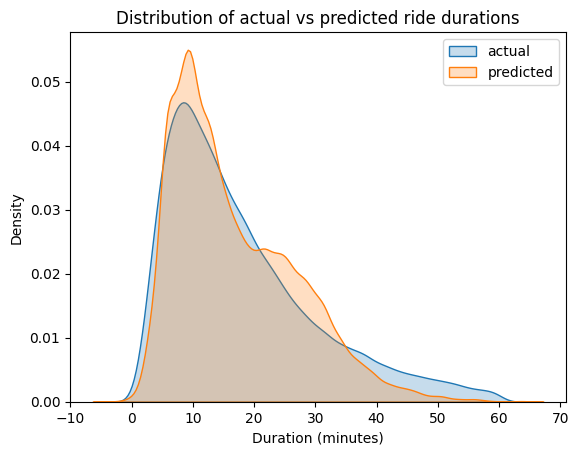

In [17]:
sns.kdeplot(y_val, label ='actual', shade=True)
sns.kdeplot(y_train_pred, label = 'predicted', shade=True)
plt.title('Distribution of actual vs predicted ride durations')
plt.xlabel('Duration (minutes)')
plt.legend()

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Trying out Lasso Regression

We can change the ***alpha*** value to see how it affects the model's performance.

Examples (for the model below):

- ***alpha = 0.1***    (gives mae = 9.3289), 
- ***alpha = 0.01***   (gives mae = 8.2185), 
- ***alpha = 0.001***  (gives mae = 6.4177), 
- ***alpha = 0.0001*** (gives mae = 5.0874), etc. 

We could log these observations in a spreadsheet, etc. but we could also move them into something 
called **Experiment Tracker**.

**Experiment Tracker** — A system that logs and compares model runs (parameters, metrics, artifacts, and code versions) so you can reproduce results and select the best-performing model.


In [21]:
# We can change the alpha value to see how it affects the model's performance.
# e.g. alpha = 0.1 (gives mae = 12.9091), 0.01 (gives mae = 12.2152), 0.001 (mae=12.0701), 
# 0.0001 (mae = 12.0572), etc. 
# We could log these observations in a spreadsheet, etc. but we could also move them into something 
# called 'Experiment Tracker'.
la = Lasso(alpha=0.0001)
la.fit(X_train, y_train)
y_train_pred = la.predict(X_train)

y_val_pred = la.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
mae

5.087407243625737

In [22]:
with open('models/las_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Trying out Ridge Regression

Just as we can log parameter trials when we use different hyperpaameter values, etc., we can also 'log' different models that we try out. This is done in a ***Model Registry*** 

**Model Registry** — A centralized system that versions, stores, and manages trained models along with their metadata, enabling controlled promotion from development to production.


In [23]:
rg = Ridge(alpha=1.0)
rg.fit(X_train, y_train)
y_train_pred = rg.predict(X_train)
y_val_pred = rg.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
mae

5.2089229148561875

In [24]:
with open('models/rid_reg.bin', 'wb') as f_out:
    pickle.dump((dv, rg), f_out)

### **ML Pipeline (Continuous Model Building & Deployment)**

  ***Data Collection*** — Gather raw data from databases, APIs, logs, or external sources

→ ***Data Validation*** — Check data quality, schema consistency, and detect anomalies

→ ***Data Preparation*** — Clean, transform, and split data into training and testing sets

→ ***Feature Engineering*** — Create meaningful input variables from raw data

→ ***Vectorization*** — Convert features into numerical representations suitable for modeling

→ ***Train Model*** — Learn model parameters from training data

→ ***Evaluate Model*** — Measure performance using appropriate metrics on validation/test data

→ ***Model Registry*** — Store and version trained models with metadata for traceability

→ ***Deploy to Production*** — Serve the approved model for real-time or batch inference

→ ***Monitor Performance*** — Track accuracy, drift, latency, and system health in production

→ ***Collect New Data*** — Gather fresh data and feedback from live usage

→ ***Retrain / Update Model*** — Rebuild or fine-tune the model using updated data

→ ***Redeploy*** — Replace or upgrade the production model with the improved version

→ ***Monitor Performance*** — Continuously observe behavior to detect degradation or drift

→ ***… (continuous loop)*** — Repeat the cycle to maintain and improve model performance over time
